# Training the model for object detection SSD300

In [1]:
import datasets
import decorator
import time
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
from model import SSD300, MultiBoxLoss
from datasets import PascalVOCDataset
from utils import *
import numpy as np

In [2]:
# Data parameters
data_folder = '/media/bruno/HD-Arquivos2/Data_Object_Detect/'  # folder with data files

# Model parameters
# Not too many here since the SSD300 has a very specific structure
n_classes = len(label_map)  # number of different types of objects
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

keep_difficult = True  # use objects considered difficult to detect?
# Learning parameters
checkpoint = None  # path to model checkpoint, None if none
batch_size = 15  # batch size
iterations = 120000  # number of iterations to train
workers = 4  # number of workers for loading data in the DataLoader
print_freq = 200  # print training status every __ batches
lr = 1e-3  # learning rate
decay_lr_at = [80000, 100000]  # decay learning rate after these many iterations
decay_lr_to = 0.1  # decay learning rate to this fraction of the existing learning rate
momentum = 0.9  # momentum
weight_decay = 5e-4  # weight decay
grad_clip = None  # clip if gradients are exploding, which may happen at larger batch sizes (sometimes at 32) - you will recognize it by a sorting error in the MuliBox loss calculation
epocas = 20 # epochs train
cudnn.benchmark = True

In [3]:
class TrainObjDetect():
    def __init__(self, keep_difficult, checkpoint, batch_size, 
                 iterations, workers, print_freq, lr, decay_lr_at, decay_lr_to, 
                momentum, weight_decay, grad_clip):
        # Learning parameters
        self.keep_difficult = keep_difficult  # use objects considered difficult to detect
        self.checkpoint = checkpoint  # path to model checkpoint, None if none
        self.batch_size = batch_size  # batch size
        self.iterations = iterations  # number of iterations to train
        self.workers = workers  # number of workers for loading data in the DataLoader
        self.print_freq = print_freq  # print training status every __ batches
        self.lr = lr  # learning rate
        self.decay_lr_at = decay_lr_at  # decay learning rate after these many iterations
        self.decay_lr_to = decay_lr_to  # decay learning rate to this fraction of the existing learning rate
        self.momentum = momentum  # momentum
        self.weight_decay = weight_decay  # weight decay
        self.grad_clip = grad_clip  # clip if gradients are exploding, which may happen at larger batch sizes (sometimes at 32) - you will recognize it by a sorting error in the MuliBox loss calculation
    
    def trainModel(self, train_loader, model, criterion, optimizer, epoch):
        """
        :param train_loader: DataLoader for training data
        :param model: model
        :param criterion: MultiBox loss
        :param optimizer: optimizer
        :param epoch: epoch number
        """
        model.train()  # training mode enables dropout

        batch_time = AverageMeter()  # forward prop. + back prop. time
        data_time = AverageMeter()  # data loading time
        losses = AverageMeter()  # loss

        start = time.time()
        #loss_interation = []
            # Batches
        for i, (images, boxes, labels, _) in enumerate(train_loader):
            data_time.update(time.time() - start)

            # Move to default device
            images = images.to(device)  # (batch_size (N), 3, 300, 300)
            boxes = [b.to(device) for b in boxes]
            labels = [l.to(device) for l in labels]

            # Forward prop.
            predicted_locs, predicted_scores = model(images)  # (N, 8732, 4), (N, 8732, n_classes)

            # Loss
            loss = criterion(predicted_locs, predicted_scores, boxes, labels)  # scalar

            # Backward prop.
            optimizer.zero_grad()
            loss.backward()

            # Clip gradients, if necessary
            if self.grad_clip is not None:
                clip_gradient(optimizer, self.grad_clip)

            # Update model
            optimizer.step()

            losses.update(loss.item(), images.size(0))
            batch_time.update(time.time() - start)

            start = time.time()
            #loss_interation.append(loss) ## Loss interation

            # Print status
            if i % self.print_freq == 0:
                print('Epoch: [{0}][{1}/{2}]\t'
                      'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Data Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(epoch, i, len(train_loader),
                                                                      batch_time=batch_time,
                                                                      data_time=data_time, loss=losses))
        
        del predicted_locs, predicted_scores, images, boxes, labels  # free some memory since their histories may be stored
        #return loss_interation 

    
    
    def startTrain(self, epochs , data_folder):
        """
        Training.
        """
        
        global start_epoch, label_map
        # Initialize model or load checkpoint
        if self.checkpoint is None:
            start_epoch = 0
            model = SSD300(n_classes=n_classes)
            # Initialize the optimizer, with twice the default learning rate for biases, as in the original Caffe repo
            biases = list()
            not_biases = list()
            for param_name, param in model.named_parameters():
                if param.requires_grad:
                    if param_name.endswith('.bias'):
                        biases.append(param)
                    else:
                        not_biases.append(param)
            optimizer = torch.optim.SGD(params=[{'params': biases, 'lr': 2 * lr}, {'params': not_biases}],
                                        lr= self.lr, momentum= self.momentum, weight_decay= self.weight_decay)
    
        else:
            self.checkpoint = torch.load(self.checkpoint)
            start_epoch = self.checkpoint['epoch'] + 1
            print('\nLoaded checkpoint from epoch %d.\n' % start_epoch)
            model = self.checkpoint['model']
            optimizer = self.checkpoint['optimizer']
    
        # Move to default device
        model = model.to(device)
        criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy).to(device)
    
        # Custom dataloaders
        train_dataset = PascalVOCDataset(data_folder,
                                         split='train',
                                         keep_difficult=self.keep_difficult)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = self.batch_size, shuffle=True,
                                                   collate_fn=train_dataset.collate_fn, num_workers= self.workers,
                                                   pin_memory=True)  # note that we're passing the collate function here
    
        # Calculate total number of epochs to train and the epochs to decay learning rate at (i.e. convert iterations to epochs)
        # To convert iterations to epochs, divide iterations by the number of iterations per epoch
        # The paper trains for 120,000 iterations with a batch size of 32, decays after 80,000 and 100,000 iterations
        #epochs = self.iterations // (len(train_dataset) // 32)
        self.decay_lr_at = [it // (len(train_dataset) // 32) for it in self.decay_lr_at]
    
        # Epochs
        #los_epochs = []
        for epoch in range(start_epoch, epochs):
    
            # Decay learning rate at particular epochs
            if epoch in self.decay_lr_at:
                adjust_learning_rate(optimizer, self.decay_lr_to)
    
            # One epoch's training
            self.trainModel(train_loader=train_loader,
                  model=model,
                  criterion=criterion,
                  optimizer=optimizer,
                  epoch=epoch)
            #los_epochs.append(loss)
    
            # Save checkpoint
            save_checkpoint(epoch, model, optimizer)
        #return los_epochs

In [4]:
train_obj = TrainObjDetect(keep_difficult, checkpoint, batch_size, iterations, 
                          workers, print_freq, lr, decay_lr_at, decay_lr_to, momentum,
                          weight_decay, grad_clip)

In [5]:
# 20 epochs of train model
loss = train_obj.startTrain(epocas,data_folder)


Loaded base model.



/home/bruno/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch: [0][0/1104]	Batch Time 10.047 (10.047)	Data Time 1.194 (1.194)	Loss 23.0746 (23.0746)	
Epoch: [0][200/1104]	Batch Time 0.693 (0.740)	Data Time 0.000 (0.006)	Loss 6.9199 (9.9827)	
Epoch: [0][400/1104]	Batch Time 0.643 (0.705)	Data Time 0.000 (0.003)	Loss 6.2294 (8.1235)	
Epoch: [0][600/1104]	Batch Time 0.683 (0.696)	Data Time 0.000 (0.002)	Loss 6.0676 (7.4126)	
Epoch: [0][800/1104]	Batch Time 0.666 (0.687)	Data Time 0.000 (0.002)	Loss 5.8432 (7.0298)	
Epoch: [0][1000/1104]	Batch Time 0.813 (0.683)	Data Time 0.000 (0.002)	Loss 5.6791 (6.7741)	


/home/bruno/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type SSD300. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/bruno/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type VGGBase. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/bruno/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/bruno/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type MaxPool2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won

Epoch: [1][0/1104]	Batch Time 2.426 (2.426)	Data Time 1.662 (1.662)	Loss 5.1051 (5.1051)	
Epoch: [1][200/1104]	Batch Time 0.712 (0.714)	Data Time 0.000 (0.009)	Loss 5.9703 (5.5153)	
Epoch: [1][400/1104]	Batch Time 0.735 (0.709)	Data Time 0.000 (0.005)	Loss 5.3970 (5.4479)	
Epoch: [1][600/1104]	Batch Time 0.638 (0.696)	Data Time 0.000 (0.003)	Loss 4.7488 (5.3916)	
Epoch: [1][800/1104]	Batch Time 0.671 (0.685)	Data Time 0.000 (0.003)	Loss 5.2264 (5.3348)	
Epoch: [1][1000/1104]	Batch Time 0.696 (0.685)	Data Time 0.000 (0.002)	Loss 4.8679 (5.2705)	
Epoch: [2][0/1104]	Batch Time 1.910 (1.910)	Data Time 1.192 (1.192)	Loss 5.3417 (5.3417)	
Epoch: [2][200/1104]	Batch Time 0.690 (0.724)	Data Time 0.000 (0.006)	Loss 4.9073 (4.9147)	
Epoch: [2][400/1104]	Batch Time 0.721 (0.721)	Data Time 0.000 (0.003)	Loss 5.2229 (4.8718)	
Epoch: [2][600/1104]	Batch Time 0.649 (0.700)	Data Time 0.001 (0.002)	Loss 4.4781 (4.8239)	
Epoch: [2][800/1104]	Batch Time 0.663 (0.684)	Data Time 0.000 (0.002)	Loss 4.9044 (

Epoch: [15][1000/1104]	Batch Time 0.651 (0.674)	Data Time 0.000 (0.002)	Loss 3.4772 (3.2893)	
Epoch: [16][0/1104]	Batch Time 2.631 (2.631)	Data Time 1.837 (1.837)	Loss 3.4304 (3.4304)	
Epoch: [16][200/1104]	Batch Time 0.633 (0.665)	Data Time 0.000 (0.009)	Loss 3.4545 (3.2712)	
Epoch: [16][400/1104]	Batch Time 0.647 (0.657)	Data Time 0.000 (0.005)	Loss 2.9126 (3.2443)	
Epoch: [16][600/1104]	Batch Time 0.753 (0.657)	Data Time 0.000 (0.003)	Loss 2.5579 (3.2372)	
Epoch: [16][800/1104]	Batch Time 0.670 (0.660)	Data Time 0.000 (0.003)	Loss 3.1906 (3.2489)	
Epoch: [16][1000/1104]	Batch Time 0.671 (0.662)	Data Time 0.000 (0.002)	Loss 2.8897 (3.2448)	
Epoch: [17][0/1104]	Batch Time 3.395 (3.395)	Data Time 2.584 (2.584)	Loss 3.0759 (3.0759)	
Epoch: [17][200/1104]	Batch Time 0.719 (0.709)	Data Time 0.000 (0.013)	Loss 3.7139 (3.2036)	
Epoch: [17][400/1104]	Batch Time 0.755 (0.705)	Data Time 0.000 (0.007)	Loss 3.2345 (3.2117)	
Epoch: [17][600/1104]	Batch Time 0.650 (0.701)	Data Time 0.000 (0.005)	L

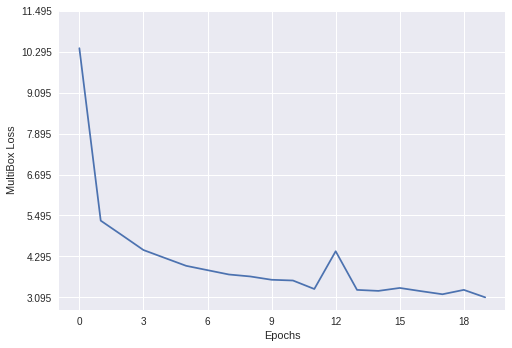

In [22]:
# Plot learning curve
import numpy as np
import matplotlib.pyplot as plt
loss = [10.3995, 5.3442, 4.9159, 4.4828, 4.2506, 4.0195, 3.8923, 3.7656, 3.7078, 3.6107,
        3.5890, 3.3405, 4.4467, 3.3141, 3.2846, 3.37068, 3.2764, 3.1860, 3.3143, 3.0955]
x = np.array(range(len(loss)))
plt.plot( x, loss) 
plt.yticks(np.arange(min(loss), 12, 1.2))
plt.xticks(np.arange(min(x), 21, 3))
plt.xlabel("Epochs")
plt.ylabel(" MultiBox Loss")
plt.style.use('seaborn')
plt.show()